In [1]:
from pathlib import Path
import tarfile
import re
import pandas as pd
import scanpy as sc

In [2]:
meta = pd.read_csv("TableS1-XenopusMCE_allmetadata.tsv", sep="\t")
meta["CellBarcode"] = meta["CellBarcode"].str.strip()
meta = meta.set_index("CellBarcode")

In [5]:
print(meta.head())

                      Stages     CellType Phenograph  Pseudotime_Pltr  \
CellBarcode                                                             
st08_AAACGGGCAGTCAGCC   st08  Pluripotent         P2         0.060110   
st08_AAACCTGCAATTCCTT   st08  Pluripotent         P2         0.093334   
st08_AACCGCGAGCAGGTCA   st08  Pluripotent         P2         0.069792   
st08_AAAGATGAGATACACA   st08  Pluripotent         P2         0.054663   
st08_AACGTTGGTCGACTGC   st08  Pluripotent         P2         0.046804   

                       Differentiation Potential_Pltr Per Stage Louvain  \
CellBarcode                                                               
st08_AAACGGGCAGTCAGCC                        1.004686            0_st08   
st08_AAACCTGCAATTCCTT                        1.004656            0_st08   
st08_AACCGCGAGCAGGTCA                        1.004663            0_st08   
st08_AAAGATGAGATACACA                        1.004684            0_st08   
st08_AACGTTGGTCGACTGC                 

In [6]:
def stage_from_name(name: str):
    m = re.search(r"St(\d+)", name)
    if not m:
        return None
    s = m.group(1)
    if s == "105":
        return "st10.5"
    if len(s) == 1:
        s = f"0{s}"
    return f"st{s}"

In [13]:
def load_one(tar_path: Path):
    out_dir = tar_path.with_suffix("").with_suffix("")
    if out_dir.exists():
        pass
    out_dir.mkdir(exist_ok=True)

    # 1) Read .tar.gz and extract
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=out_dir)

    # 2) Find h5 after extraction
    h5 = None
    for name in ("filtered_gene_bc_matrices_h5.h5", "filtered_feature_bc_matrix.h5"):
        matches = list(out_dir.rglob(name))
        if matches:
            h5 = matches[0]
            break
    if h5 is None:
        raise FileNotFoundError(f"No filtered h5 found in {out_dir}")

    # 3) Load
    adata = sc.read_10x_h5(h5)
    adata.var_names_make_unique()

    stage = stage_from_name(tar_path.name) or stage_from_name(str(h5))
    adata.obs["barcode_base"] = adata.obs_names.str.replace(r"-1$", "", regex=True)
    adata.obs["CellBarcode"] = stage + "_" + adata.obs["barcode_base"]
    adata.obs = adata.obs.join(meta, on="CellBarcode", how="left")
    adata.obs["stage_from_file"] = stage

    missing = adata.obs["CellType"].isna().sum()
    print(tar_path.name, stage, "cells", adata.n_obs, "missing_meta", missing, "matches", adata.n_obs - missing)
    return adata


In [14]:
root = Path("GSE158088_RAW")
tar_paths = sorted(root.glob("*.tar.gz"))

adatas = [load_one(p) for p in tar_paths]

# Optional: merge all stages
adata_all = sc.concat(adatas, join="outer", label="sample",
                      keys=[p.stem for p in tar_paths], index_unique="-")

GSM4790535_scCapSt08_count.out.tar.gz st08 cells 9365 missing_meta 5957 matches 3408
GSM4790536_scCapSt105_count.v3.out.tar.gz st10.5 cells 2349 missing_meta 1088 matches 1261
GSM4790537_scCapSt12_count.v3.out.tar.gz st12 cells 1685 missing_meta 817 matches 868
GSM4790538_scCapSt13_count.out.tar.gz st13 cells 20267 missing_meta 16125 matches 4142
GSM4790539_scCapSt16_count.out.tar.gz st16 cells 4935 missing_meta 2489 matches 2446
GSM4790540_scCapSt18_count.out.tar.gz st18 cells 9741 missing_meta 6370 matches 3371
GSM4790541_scCapSt20_count.out.tar.gz st20 cells 6058 missing_meta 3378 matches 2680
GSM4790542_scCapSt22_count.v3.out.tar.gz st22 cells 5799 missing_meta 603 matches 5196
GSM4790543_scCapSt24_count.out.tar.gz st24 cells 10005 missing_meta 6919 matches 3086
GSM4790544_scCapSt27_count.out.tar.gz st27 cells 5263 missing_meta 1921 matches 3342


In [12]:
print(adata_all)

AnnData object with n_obs × n_vars = 75467 × 41560
    obs: 'barcode_base', 'CellBarcode', 'Stages', 'CellType', 'Phenograph', 'Pseudotime_Pltr', 'Differentiation Potential_Pltr', 'Per Stage Louvain', 'CytoTRACE', 'CV', 'CCphase', 'Branch Probabilities Basal', 'Branch Probabilities Goblet', 'Branch Probabilities Ionocytes', 'Branch Probabilities Multiciliated', 'stage_from_file', 'sample'


In [15]:
adata_all.obs["in_meta"] = adata_all.obs["CellBarcode"].isin(meta.index)
adata_all.obs["in_meta"].value_counts()

in_meta
False    41482
True     33985
Name: count, dtype: int64

In [16]:
adata_barcodes = pd.Index(adata_all.obs["CellBarcode"])
meta_barcodes = meta.index

# missing meta (should be 5)
missing_in_adata = meta_barcodes.difference(adata_barcodes)
print("missing_in_adata:", len(missing_in_adata))
print(missing_in_adata[:10])

missing_in_adata: 5
Index(['st22_ATCATTCTCATCGTAG', 'st22_CTAGACACACACGGAA',
       'st22_GATCGTACACGTCGGT', 'st22_GTTACCCTCAACCCGG',
       'st22_GTTAGACCAAGAATAC'],
      dtype='object', name='CellBarcode')


In [18]:
# save full object
adata_all.write("adata_all.h5ad")


In [25]:
adata_annot = adata_all[adata_all.obs["Phenograph"].notna()].copy()
print(adata_annot)

AnnData object with n_obs × n_vars = 33985 × 41560
    obs: 'barcode_base', 'CellBarcode', 'Stages', 'CellType', 'Phenograph', 'Pseudotime_Pltr', 'Differentiation Potential_Pltr', 'Per Stage Louvain', 'CytoTRACE', 'CV', 'CCphase', 'Branch Probabilities Basal', 'Branch Probabilities Goblet', 'Branch Probabilities Ionocytes', 'Branch Probabilities Multiciliated', 'stage_from_file', 'sample', 'in_meta'


In [22]:
meta_annot = meta[meta["CellType"].notna()]
print(meta_annot.shape)

(29804, 13)


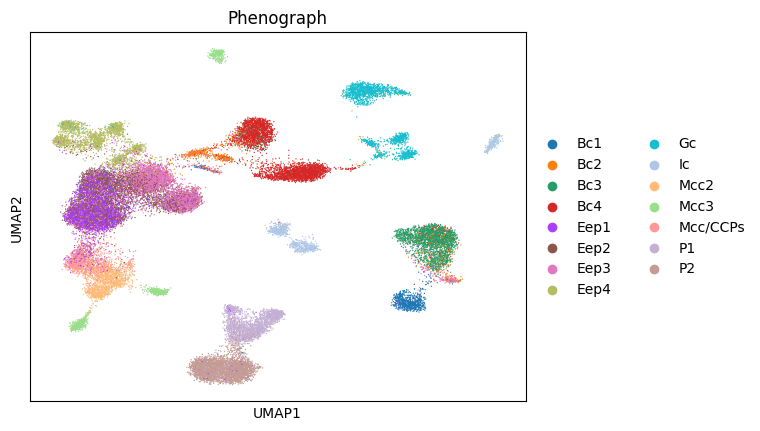

In [26]:
adata = adata_annot
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata); sc.pp.neighbors(adata); sc.tl.umap(adata)
sc.pl.umap(adata, color=["Phenograph"])